In [6]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
asset_type = "building"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [55]:
start_year = 2006
eval_start_year = 2020  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by count
# df["weight"] = df["count"].apply(lambda x: 1 + np.log10(x))

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
train_df = train_df[~train_df[metric_pct_chg].isna()].reset_index(drop=True)

eval_df = df[df["year"] >= eval_start_year]
eval_df = eval_df[~eval_df[metric_pct_chg].isna()].reset_index(drop=True)

# Finally
df = df.fillna(0)

print(f"Train: {train_df.shape}, Eval: {eval_df.shape}")
# Try only for building. Try training separately for building. 

Train: (12361, 53), Eval: (3422, 53)


In [56]:
log_normalize_columns = [
    # metric,
    # "count",
    # "total_traded_area",
    # "in_migrations",
    # "out_migrations",
    # "population",
    # "taxpayer_count",
    # "taxable_income",
    # "taxable_income_per_taxpayer",
    # "total_tax",
    # "new_dwellings",
    # "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "yearly_price_growth",
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
    # "migrations_is_available",
    # "taxable_income_is_available",
    # "dwellings_is_available",
    # "total_tax_is_available",
    # "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
    + ["time_diff"] # assigned by TimeSeriesDataset
)

final_columns = id_columns + feature_columns

In [57]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    shift=years_ahead
)

#### Cumulative Taxable Income Growth to Target

In [89]:
cumulative_df = pd.DataFrame(
    columns=[f"cumulative_{column}" for column in feature_columns] + ["target"]
)
avg_df = pd.DataFrame(
    columns=[f"avg_{column}" for column in feature_columns] + ["target"]
)

for i, sample in enumerate(time_series_dataset):
    cumulative_df = cumulative_df.append(
        {
            **{
                f"cumulative_{variable}": (1 + sample["window"][variable])
                .cumprod()
                .iloc[-1]
                - 1
                for variable in feature_columns
            },
            **{"target": sample["target"].values[0]},
        },
        ignore_index=True,
    )

    avg_df = avg_df.append(
        {
            **{
                f"avg_{variable}": sample["window"][variable].mean()
                for variable in feature_columns
            },
            **{"target": sample["target"].values[0]},
        },
        ignore_index=True,
    )

<Axes: xlabel='cumulative_total_tax_growth', ylabel='target'>

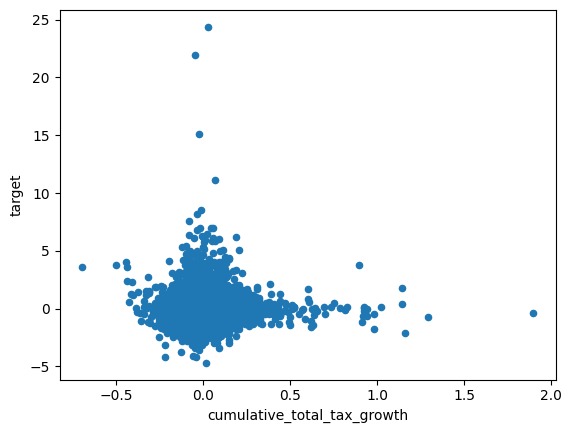

In [90]:
variable = f"total_tax_growth"
factor_df = cumulative_df[[f"cumulative_{variable}", "target"]]
factor_df = factor_df[factor_df["target"].abs() < 2 ]
factor_df = factor_df[factor_df[f"cumulative_{variable}"].abs() < 5]
cumulative_df.plot.scatter(x=f"cumulative_{variable}", y="target")

In [93]:
avg_df

,avg_unit_price_median_smoothed_pct_chg_normalized_yearly,avg_yearly_price_growth_normalized_yearly,avg_count_growth_normalized_yearly,avg_total_tax_growth_normalized_yearly,avg_taxable_income_growth_normalized_yearly,avg_taxable_income_per_taxpayer_growth_normalized_yearly,avg_net_migration_ratio_normalized_yearly,avg_new_dwellings_ratio_normalized_yearly,avg_taxpayer_count_growth_normalized_yearly,avg_unit_price_median_smoothed_pct_chg,avg_count_growth,avg_total_tax_growth,avg_taxable_income_growth,avg_taxable_income_per_taxpayer_growth,avg_net_migration_ratio,avg_new_dwellings_ratio,avg_taxpayer_count_growth,avg_time_diff,target
0,0.000000,0.000000,0.000000,0.086815,0.142773,-0.046756,-0.344226,0.000000,0.275400,0.000000,0.000000,0.037875,0.006867,-0.021915,-0.008906,0.000000,0.029427,0.4,-1.796358
1,0.000000,0.000000,0.000000,-0.104729,0.188863,-0.121483,0.420264,-0.317848,0.424967,0.000000,0.000000,0.009923,0.008807,-0.023968,-0.001199,0.017541,0.033579,0.4,0.232899
2,0.000000,0.000000,0.000000,0.031756,0.386411,0.534708,0.563263,0.863529,0.051261,0.000000,0.000000,0.029840,0.017121,-0.005946,0.000243,0.033283,0.023205,0.4,0.821754
3,0.000000,0.000000,0.000000,0.248126,1.557118,2.546599,1.001287,0.880950,-0.198130,0.000000,0.000000,0.061415,0.066393,0.049309,0.004659,0.033515,0.016281,0.4,-1.074886
4,0.000000,0.000000,0.000000,-0.076018,0.643132,0.129862,0.337140,-0.536044,0.864171,0.000000,0.000000,0.014112,0.027926,-0.017065,-0.002037,0.014634,0.045771,0.4,-0.453476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12356,0.365883,0.310185,-0.331585,0.074379,-0.087524,-0.028805,-0.628643,-0.779212,-0.109350,0.079677,-0.057584,0.005637,0.008546,0.006581,-0.008683,0.008648,0.002047,0.8,-0.489022
12357,-0.066311,-0.203641,-0.267752,1.724838,3.067797,3.844568,-0.744789,0.000000,-0.192950,-0.006727,-0.037468,0.056959,0.149554,0.147864,-0.009682,0.000000,0.001312,0.8,-0.415265
12358,-0.193363,-0.318895,-0.003512,-0.104402,0.068264,0.039044,-0.441454,0.000000,-0.045744,-0.028487,0.057071,-0.001819,0.016817,0.007836,-0.007125,0.000000,0.008831,0.8,-0.941386
12359,0.277472,0.297693,-0.298526,0.386245,0.529136,0.043607,1.177673,0.352487,0.986790,0.063373,-0.044511,0.025873,0.037090,0.009530,0.006162,0.016946,0.027327,0.8,-0.101795


KeyError: 'avg_total_tax_growth'

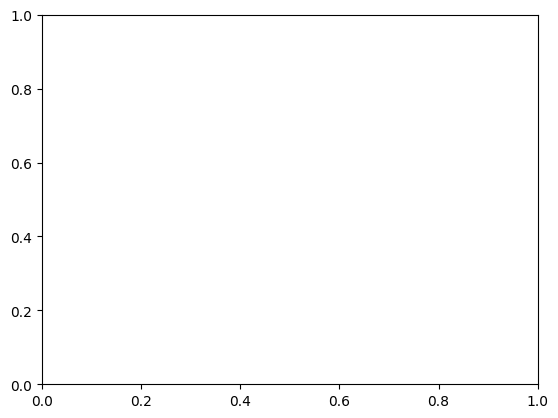

In [92]:
variable = f"total_tax_growth"
variable2 = f"count_growth"
factor_df = avg_df[[f"avg_{variable}", "target"]]
factor_df = factor_df[factor_df["target"].abs() < 2 ]
factor_df = factor_df[factor_df[f"avg_{variable}"].abs() < 5]
cumulative_df.plot.scatter(x=f"avg_{variable}", y="target")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


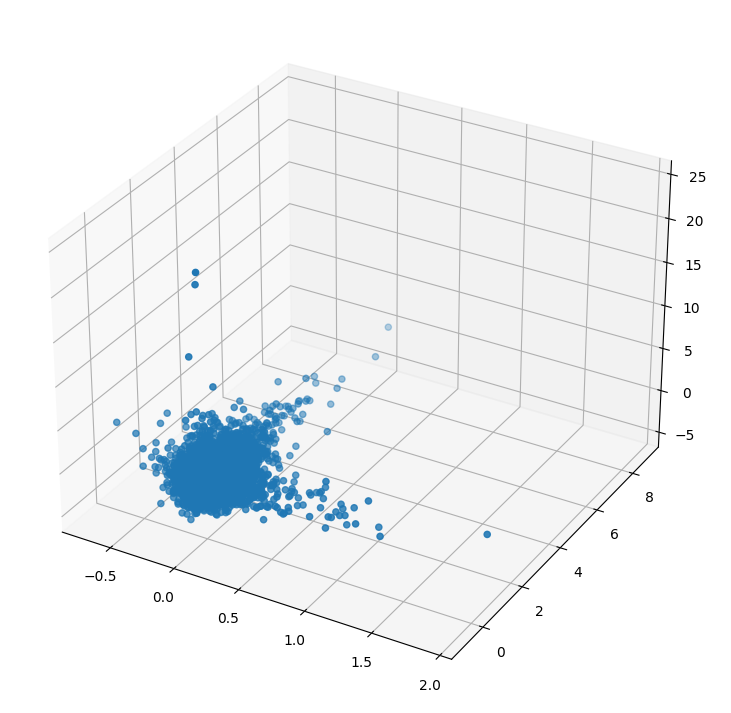

In [86]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=cumulative_df[f"cumulative_{variable}"].values, ys=cumulative_df[f"cumulative_{variable2}"].values, zs=cumulative_df["target"].values)

ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
plt.show()